# Heat-Wave Hazard

For The heat-wave we use the EURO-CORDEX (or Chelsa only to consider) daily maximum temperature data. We used the methodology from the PESETA IV project https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en

Specifically, a Heat-Wave is defined as a period ≥ 3 consecutive days with maximum temperature above a daily threshold calculated for a 30-year-long reference period (for the purpose of testing we choose shorter period). At least 30-year time series of daily vales are needed to obtain a robust estimation of the indicator. The threshold is defined as the 90th percentile of daily maxima temperature, centred on a 31-day window.

For the Calculation of the Heat wave you can follow these next steps:

- Firstly look at the CLIMAAX hazard portal, if your area should suffer by Heat-Wave more frequently in the future (all these maps will be added)
- Secondly look at the climateadapt webpages:
    1. Heat days occurence in the past [https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days]
    2. Heat days occurence in the future [https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days]
    3. Tropical nights [https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/]
  
If you whant to produce a Heat wave graphs with your own data you can use this toolbox:
1. Import the packages
2. Create a directory structure
3. Set the crs for the Euro-Cordex data
4. Download the data from the:
- CDS [https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=form] (suggested, and used by this toolbox)
- Or Chelsa [ https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F ### https://chelsa-climate.org/]
- Or use your own data.
6. Load a data convert Kelvin to Celsius
7. Calculate the Heat wave occurence for past and future
8. Plot the results and compare
9. Conclusion

# 1. Import packages

In [21]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
from osgeo import gdal # Geo data handling 
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# 2. Create a directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

# 3. Set a Cooridinate system

In [3]:
## CRS for Eurocordex data
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

In [1]:
## You can also use the GDAL warp for the crs setting

# 4. Download a data from the CDS

You can download a data from the CDS with the API

- Firstly you download a data for the past
- Secondly data for the future you can select the Climate scenario rcp 4.5 and 8.5

Based on the PesetaIV methodology you need to download at least 30 year period, to see a change in the Heat wave occurence. The most frequently 30 year periods used by the CDS are:

- for the past: 1971-2000 
- for the future: 2011-2040, 2041-2070 and 2070-2100

Or you can use your own data for computing.


1971-2000

In [ ]:
## Data for the 1971-2000
# Change KEY!!!
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34"
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_45_1971_2000.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_1971_2000.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_1971_2000.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

2011-2040 rcp_8_5 (or you can select other suggested period or rcp)

In [ ]:
# Change KEY!!!
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34"
c = cdsapi.Client(url=URL, key=KEY)

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2040.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', 
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040',
        ],
    },
   f"{data_dir}/era5_daily_t2m_eurminmax_2011_2040.zip")

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'era5_daily_t2m_eurminmax_2011_2040.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# 5. Load data and convert Kelvin to Celsius

In [ ]:
# 1. Data are for 5 year periods, you can select one which you prefer or merge all in one... 
dmax = xr.open_mfdataset(f'{data_dir}/tasmax*.nc', decode_coords='all')
# 2. Convert from K to °C
dmax=dmax['tasmax']
tasmax=dmax - 273.15
tasmax=tasmax.assign_attrs(dmax.attrs)
tasmax.attrs['units']='°C'
# Select a time period
tasmaxh=tasmax.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1=tasmax.sel(time=slice("2011-01-01", "2040-12-31"))
#tasmaxp2=tasmax.sel(time=slice("2041-01-01", "2070-12-31")) # You can select your own time period
#tasmaxp3=tasmax.sel(time=slice("1971-01-01", "2100-12-31")) # You can select your own time period
# Clip tasmax to Your area or continue with dat for whole Europe
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
tasmax.rio.write_crs(rotated_pole, inplace=True)
tasmaxPILOT=tasmax.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,) #select your own coordintes
## 

# 6. Calculation of the Heat-Wave events based on the Peseta IV methodology

### For the historical data 1971-2000

In [ ]:
# Divide the time series to months 
tasmax_month=tasmaxh.groupby('time.month').groups
#aty=at_city.groupby('time.year').groups
# Calculate the heat wave occurence for all months in given period  
for i in range (1, 13):
    tasmax_idxs=tasmax_month[i]
    # Extract the  months by selecting the relevant indices
    #at_max=at_city.isel(time=at_idxs)
    tas_maxh=tasmaxh.isel(time=tasmax_idxs)   
    # 90 percentile 
    #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_max90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')   
    heatpt=xr.where(tas_maxh>tas_max90, 1, 0)
    # Create + time dataset
    vat=heatpt
    v1at=heatpt[:-1,:,:]
    v2at=heatpt[:-2,:,:]
    v3at=heatpt[:-3,:,:]
    # Create missing days
    t1at=heatpt[0:1,:,:]
    t2at=heatpt[0:2,:,:]
    t3at=heatpt[0:3,:,:]
    # Concatenate missing dates to + time dataset
    vi1at=xr.concat([t1at, v1at], dim='time')
    vi2at=xr.concat([t2at, v2at], dim='time')
    vi3at=xr.concat([t3at, v3at], dim='time')
    # Change the time dimesion for correct one
    tiat=heatpt["time"]
    # add a time dimension
    vi1at["time"]=tiat
    vi2at["time"]=tiat
    vi3at["time"]=tiat
    # Sum of the Heat-Wave
    sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
    sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)    
    sumvatf=sumvat+sumv2at
    for j in range (1971,1976):     # 2051 is exclusive
        sumvyp=sumvatf.groupby('time.year').groups  
        sat1p=sumvyp[j]
        sumt1p=sumvatf.isel(time=sat1p) 
        sumyear1p=sumt1p.sum(dim='time')
        sumyear1p.rio.to_raster(raster_path=f'{data_dir}/HW_1971_2000_rcp8.5/HW_' + str(j) + '_hYM_' + str(i) + '.tif')

### For the projections data 2011-2040 ... (2041-2070, 2071-2100)

- For the extraction of th Heatwave events in the future we use the 90percentile treshold from the reference period 1971-2000

In [ ]:
# Divide the time series to months 
tasmax_month=tasmaxh.groupby('time.month').groups
tasmax_montp1=tasmaxp1.groupby('time.month').groups
#aty=at_city.groupby('time.year').groups
# Calculate the heat wave occurence for all months in given period  
for i in range (1, 13):
    tasmaxh_idxs=tasmax_month[i]
    tasmaxp1_idxs=tasmax_montp1[i]
    # Extract the  months by selecting the relevant indices
    #at_max=at_city.isel(time=at_idxs)
    tas_maxh=tasmaxh.isel(time=tasmaxh_idxs)
    tas_maxp1=tasmaxp1.isel(time=tasmaxp1_idxs)    
    # 90 percentile 
    #junq90_maxZA=jun_maxZA.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')
    tas_maxp190=tas_maxp1.chunk(dict(time=-1)).quantile(0.90,'time')
    heatp1t=xr.where(tas_maxp1>tas_maxh90, 1, 0)
    # Create + time dataset
    vat=heatp1t
    v1at=heatp1t[:-1,:,:]
    v2at=heatp1t[:-2,:,:]
    v3at=heatp1t[:-3,:,:]
    # Create missing days
    t1at=heatp1t[0:1,:,:]
    t2at=heatp1t[0:2,:,:]
    t3at=heatp1t[0:3,:,:]
    # Concatenate missing dates to + time dataset
    vi1at=xr.concat([t1at, v1at], dim='time')
    vi2at=xr.concat([t2at, v2at], dim='time')
    vi3at=xr.concat([t3at, v3at], dim='time')
    # Change the time dimesion for correct one
    tiat=heatp1t["time"]
    # add a time dimension
    vi1at["time"]=tiat
    vi2at["time"]=tiat
    vi3at["time"]=tiat
    # Sum of the Heat-Wave
    sumvat=xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
    sumv2at=xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)  
    sumvatf=sumvat+sumv2at
    for j in range (2011,2041):     # 2051 is exclusive
        sumvyp=sumvatf.groupby('time.year').groups 
        sat1p=sumvyp[j]
        sumt1p=sumvatf.isel(time=sat1p)
        sumyear1p=sumt1p.sum(dim='time')
        sumyear1p.rio.to_raster(raster_path=f'{data_dir}/HW_2011_2040_rcp8.5/HW_' + str(j) + '_projYM_' + str(i) + '.tif')

### Sum the Heat Wave events by month and years and plot the results

#### Sum of the Heat wave events by months Historical

In [ ]:
for i in range (1,13):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_1971_2000_rcp8.5/*hYM_' + str(i) + '.tif')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUhM_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
#
for i in range (1, 13):    
    HWEUpm=f'{data_dir}/stackHWEUhM_' + str(i) + '.tif'
    HWEUpm= xr.open_dataset(HWEUpm)
    HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUpm=HWEUpm['band_data']
    HWEUpm.rio.to_raster(raster_path=f'{data_dir}/HWsumhM_' + str(i) + '.tif')
#
HW = sorted (glob(f'{data_dir}/HWsumhM_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumM_1971_2000.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

(0.0, 30.0)

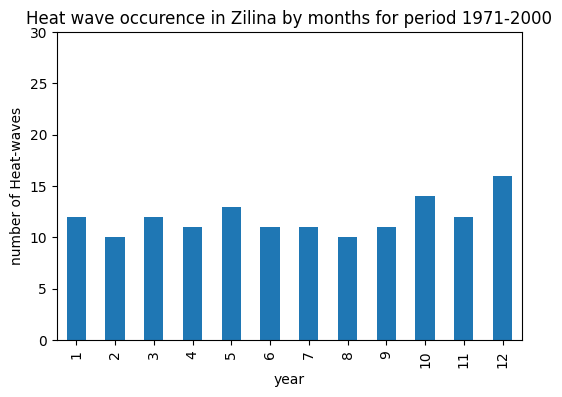

In [4]:
HWbarhm=f'{data_dir}/HWsumM_1971_2000.tif'
HWbarhm= xr.open_dataset(HWbarhm)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbarhm=HWbarhm['band_data']
HWbarhm.rio.write_crs(rotated_pole, inplace=True)
HWbarhm=HWbarhm.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
#ZApast=ZApast.rio.clip_box(minx=18.67, miny=49.175, maxx=18.8, maxy=49.250)
#HWyZA=HWbar.rio.clip_box(minx=18.6, miny=49, maxx=19, maxy=49.5)
HWyZAhm=HWbarhm.isel(x= 1, y=2)
# Select a pixel for plotting 
# Plot a data 
fig, ax = plt.subplots(figsize=(6, 4))
years = list(range(1, 13))
HWyhserm = HWyZAhm.to_series()
HWyhserm.plot.bar(x=years, ax=ax)
plt.title('Heat wave occurence in Zilina by months for period 1971-2000') 
ax.set_xlabel('year')
ax.set_ylabel('number of Heat-waves')
ax.set_xticklabels(years)
ax.set_ylim(0,30)

#### Sum of the Heat wave events by months Projection

In [ ]:
for i in range (1,13):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_2011_2040_rcp8.5/*projYM_' + str(i) + '.tif')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUp1M_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
###
for i in range (1, 13):    
    HWEUpm=f'{data_dir}/stackHWEUp1M_' + str(i) + '.tif'
    HWEUpm= xr.open_dataset(HWEUpm)
    HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUpm=HWEUpm['band_data']
    HWEUpm.rio.to_raster(raster_path=f'{data_dir}/HWsump1M_' + str(i) + '.tif')
###
HW = sorted (glob(f'{data_dir}/HWsump1M_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumM_2011_2040.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1)) 

(0.0, 30.0)

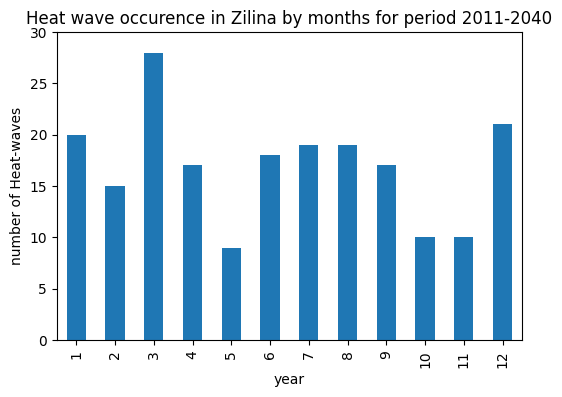

In [5]:
HWbarpm=f'{data_dir}/HWsumM_2011_2040.tif'
HWbarpm= xr.open_dataset(HWbarpm)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbarpm=HWbarpm['band_data']
HWbarpm.rio.write_crs(rotated_pole, inplace=True)
HWbarpm=HWbarpm.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
#ZApast=ZApast.rio.clip_box(minx=18.67, miny=49.175, maxx=18.8, maxy=49.250)
#HWyZA=HWbar.rio.clip_box(minx=18.6, miny=49, maxx=19, maxy=49.5)
HWyZApm=HWbarpm.isel(x= 1, y=2)
# Select a pixel for plotting 
# Plot a data 
fig, ax = plt.subplots(figsize=(6, 4))
years = list(range(1, 13))
HWypserm = HWyZApm.to_series()
HWypserm.plot.bar(x=years, ax=ax)
plt.title('Heat wave occurence in Zilina by months for period 2011-2040') 
ax.set_xlabel('year')
ax.set_ylabel('number of Heat-waves')
ax.set_xticklabels(years)
ax.set_ylim(0,30)

#### Sum of the Heat wave by years historical

In [ ]:
for i in range (1971,2001):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_1971_2000_rcp8.5/HW_' + str(i) + '*')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUhY_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
##################################################
for i in range (1971, 2001):    
    HWEUp=f'{data_dir}/stackHWEUhY_' + str(i) + '.tif'
    HWEUp= xr.open_dataset(HWEUp)
    HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUp=HWEUp['band_data']
    HWEUp.rio.to_raster(raster_path=f'{data_dir}/HWsumhY_' + str(i) + '.tif')
##################################################
# Read a paths for Heat-waves
HW = sorted (glob(f'{data_dir}/HWsumhY_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsumY_1971_2000.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))  
##
HWbar=f'{data_dir}/HWsumY_1971_2000.tif'
HWbar= xr.open_dataset(HWbar)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbar=HWbar['band_data']
HWbar.rio.write_crs(rotated_pole, inplace=True)
HWbar=HWbar.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)

(0.0, 16.0)

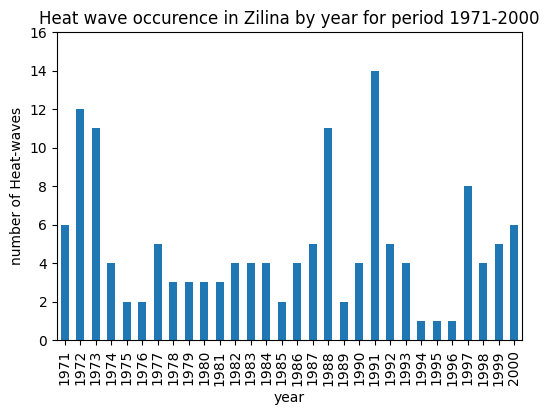

In [7]:
HWbarh=f'{data_dir}/HWsumY_1971_2000.tif'
HWbarh= xr.open_dataset(HWbarh)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbarh=HWbarh['band_data']
HWbarh.rio.write_crs(rotated_pole, inplace=True)
HWbarh=HWbarh.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
HWyZAh=HWbarh.isel(x= 1, y=2)
# Select a pixel for plotting 
# Plot a data 
fig, ax = plt.subplots(figsize=(6, 4))
years = list(range(1971, 2001))
HWyhser = HWyZAh.to_series()
HWyhser.plot.bar(x=years, ax=ax)
plt.title('Heat wave occurence in Zilina by year for period 1971-2000') 
ax.set_xlabel('year')
ax.set_ylabel('number of Heat-waves')
ax.set_xticklabels(years)
ax.set_ylim(0,16)

#### Sum of the Heat wave by years projections

In [ ]:
for i in range (2011,2041):    
    # Read a paths for Heat-waves
    HW = glob(f'{data_dir}/HW_2011_2040_rcp8.5/HW_' + str(i) + '*')
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{data_dir}/stackHWEUp1Y_' + str(i) + '.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
##################################################
for i in range (2011, 2041):    
    HWEUp=f'{data_dir}/stackHWEUp1Y_' + str(i) + '.tif'
    HWEUp= xr.open_dataset(HWEUp)
    HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
    HWEUp=HWEUp['band_data']
    HWEUp.rio.to_raster(raster_path=f'{data_dir}/HWsump1Y_' + str(i) + '.tif')
#################################################
# Read a paths for Heat-waves
HW = sorted (glob(f'{data_dir}/HWsump1Y_*'), key=os.path.getmtime)
# Create a raster stack 
with rasterio.open(HW[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(HW))
#
with rasterio.open(f'{data_dir}/HWsump1Y_2011_2040.tif','w', **meta) as dst:
    for id, layer in enumerate(HW, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))   
################################################
HWbar=f'{data_dir}/HWsump1Y_2011_2040.tif'
HWbar= xr.open_dataset(HWbar)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbar=HWbar['band_data']
HWbar.rio.write_crs(rotated_pole, inplace=True)
HWbar=HWbar.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)

(0.0, 16.0)

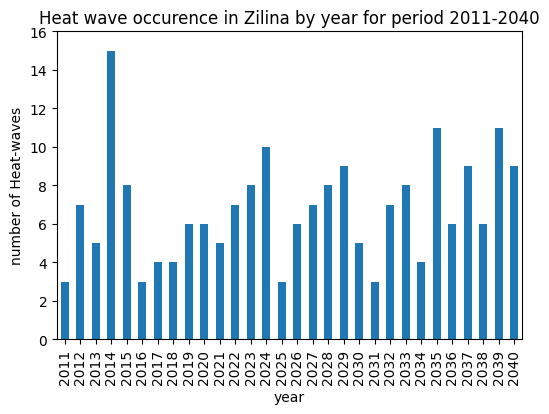

In [9]:
HWbarh=f'{data_dir}/HWsump1Y_2011_2040.tif'
HWbarh= xr.open_dataset(HWbarh)
#HWy=HWy.sum(dim='band', skipna=True,  keep_attrs=True)
HWbarh=HWbarh['band_data']
HWbarh.rio.write_crs(rotated_pole, inplace=True)
HWbarh=HWbarh.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
HWyZAh=HWbarh.isel(x= 1, y=2)
# Select a pixel for plotting 
# Plot a data 
fig, ax = plt.subplots(figsize=(6, 4))
years = list(range(2011, 2041))
HWyp1ser = HWyZAh.to_series()
HWyp1ser.plot.bar(x=years, ax=ax)
plt.title('Heat wave occurence in Zilina by year for period 2011-2040') 
ax.set_xlabel('year')
ax.set_ylabel('number of Heat-waves')
ax.set_xticklabels(years)
ax.set_ylim(0,16)

# 7. Plot the results and compare

### Comparison by months

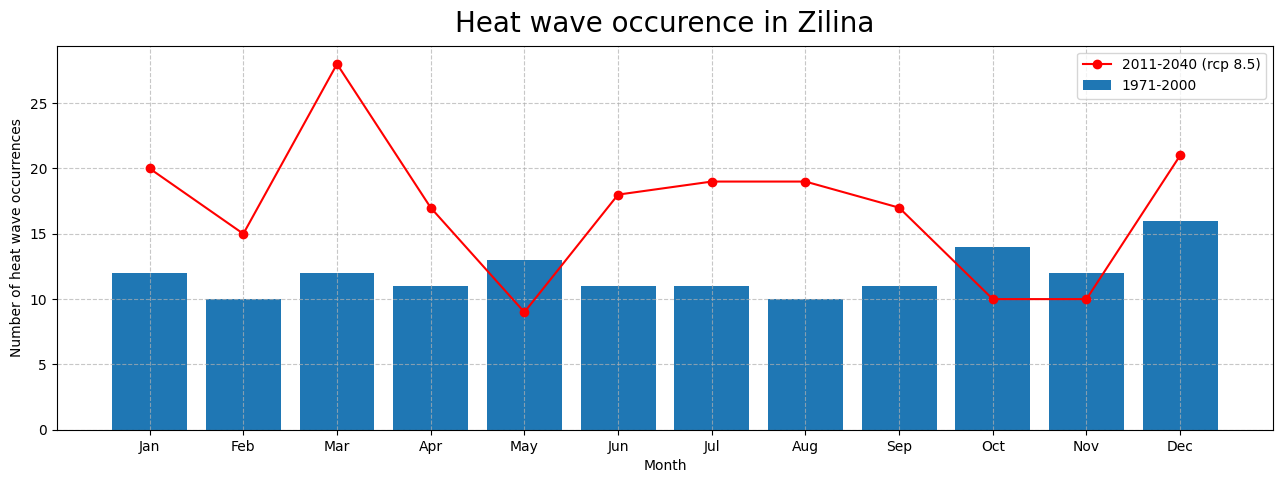

In [12]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar = HWyhserm
line = HWypserm
fig, ax = plt.subplots()
ax.bar(month, bar, label='1971-2000')
ax.plot(month, line, color='red', marker='o', label='2011-2040 (rcp 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of heat wave occurrences')
ax.set_title('Heat wave occurence in Zilina', fontsize=20, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9)
plt.show()

### Comparison by years

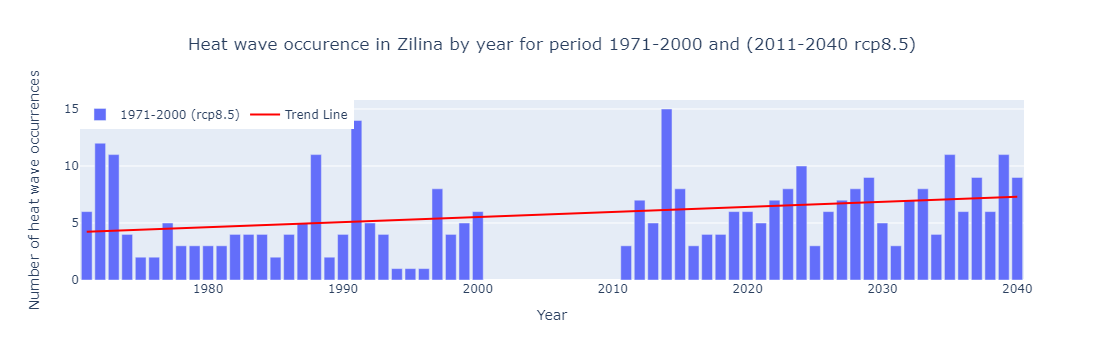

In [34]:
# merge past and future
b=pd.concat([HWyhser,HWyp1ser], axis=0)
# This is x and y of the regression line
bar = b
yearh=list(range(1971, 2001))
yearp1=list(range(2011, 2041))
g=yearh+yearp1
year = g
#Creating a data frame out of series
df = pd.DataFrame({'year': year,'bar': bar})
x = df['year'].astype(int).values.reshape(-1, 1)
y = df['bar'].values
# Calling a function for linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
fig = go.Figure()
#Adding a shape of graph
fig.add_trace(go.Bar(x=df['year'], y=df['bar'], name='1971-2000 (rcp8.5)'))
fig.add_trace(go.Scatter(x=df['year'], y=y_pred, mode='lines', name='Trend Line', line=dict(color='red')))
# Adding a description of graph
fig.update_layout(title='Heat wave occurence in Zilina by year for period 1971-2000 and (2011-2040 rcp8.5)', title_x = 0.5,
                  xaxis_title='Year',
                  yaxis_title='Number of heat wave occurrences',
                  showlegend=True,
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
                  barmode='stack')
fig.show()